## Лабораторная 1. Создание PoS-теггера

#### Петрова Мария, Цендякова Светлана.  15 фпл

### Типология Баскского языка:
1. Баскский язык (эускара, васконский), единственный язык запада Европы, не принадлежащий к индо-европейской семье.
2. Он имеет гипотетические родственные связи с языками ряда народов, проживающих в долинах Кавказских гор.
3. Типологическое сходство баскского языка с индоевропейскими языками полностью отсутствует: суффиксальный способ склонения, отсутствие грамматического рода и 
сложная глагольная морфология с маркированностью от одного до четырёх лиц в каждой финитной форме глагола.
4. Типологически баскский язык относится к агглютинативным эргативным языкам с некоторыми номинативными отклонениями. 
5. Морфология развита как в имени (категории падежа, числа, определённости), так и в глаголе (время, вид, наклонение, залог, лицо, число, в некоторых случаях род, именные формы). 
6. Есть аналитические формы (особенно в глаголе), полиперсонное спряжение [как в чукото-камчатском алюторском и ашуйском кабардинском языках].
7. Падежи имени и местоимений выражают и синтаксические, и пространственно-временные отношения [как в уральских и алтайских языках], аналоги падежей в глаголе замещают придаточные предложения.Определения образуют с именем единую группу. 
8. Порядок слов относительно свободный, но типичным считается «Субъект — Объект — Предикат». На порядок слов влияет актуальное членение предложения.

In [5]:
from conllu import parse_incr
import numpy as np
import matplotlib.pyplot as plt
import statistics as s

from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

### Дескриптивная статистика для тренировочной и тестовой выборки

In [6]:
def parse(file,sentences,tags): #не забыть передать функции пустые контейнеры для тэгов и предложений
    data = open(file,'r',encoding='utf-8')
    for tokenlist in parse_incr(data): #tokenlist - это токены одного предложения
        #print(tokenlist)
        sentence = []
        for token in tokenlist:
            sentence.append(token['form'].lower()) #берем форму слова в нижнем регистре
            tags.append(token['upostag']) #берем тэг части речи
        sentences.append(sentence) #собираем список списков
    
    return sentences,tags    

In [7]:
def tag_distribution(tags): #функция, которая считает распределение тэгов, нужно будет чуть позже для графика
    distribution = {}
    for tag in tags:
        if tag not in distribution.keys():
            distribution[tag]=tags.count(tag)            
    return distribution
    

##### Распарсим файл и получим нужные нам данные из тренировочной выборки - уникальные теги и список предложений

In [8]:
file = 'eu_bdt-ud-train.conllu'
basque_train_sentences = []
basque_train_tags = []
parse(file,basque_train_sentences,basque_train_tags)
basque_train_tag_distribution = tag_distribution(basque_train_tags)
basque_train_tags = set(basque_train_tags) #отберем только уникальные
len_train_sent = len(basque_train_sentences) #количество предложений


In [9]:
print(basque_train_tags)

{'DET', 'NOUN', 'NUM', 'PRON', 'X', 'PART', 'PUNCT', 'CCONJ', 'ADJ', 'ADV', 'VERB', 'SYM', 'AUX', 'ADP', 'PROPN', 'INTJ'}


##### Распарсим файл и получим нужные нам данные из тестовой выборки - уникальные теги и список предложений

In [10]:
file = 'eu_bdt-ud-test.conllu'
basque_test_sentences = []
basque_test_tags = []
test_sentences = parse(file,basque_test_sentences,basque_test_tags)
basque_test_tag_distribution = tag_distribution(basque_test_tags)

basque_test_tags = set(basque_test_tags) #отберем только уникальные
len_test_sent = len(basque_test_sentences) #количество предложений

#### Собираем статистику: 
Число предложений / уникальных словоформ;
Число уникальных PoS-тегов;
Максимальное и минимальное число слов в предложении;
Математическое ожидание и медиана числа слов в предложении;
Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке


In [11]:
def get_stat(sentences,tags):
    unique_words = []
    num_sent = len(sentences) #Число предложений
    words = []
    for sentence in sentences:
        words +=sentence
    unique_words = set(words)
    num_unique_words = len(unique_words) #Число уникальных словоформ;
    num_pos = len(tags) #Число уникальных PoS-тегов
    min_word_count = min(map(len, sentences)) #минимальное число слов в предложении
    max_word_count = max(map(len, sentences)) #Максимальное число слов в предложении; 
    median_word_count = s.median(map(len, sentences)) #медиана числа слов в предложении
    mean_word_count = round(s.mean(map(len,sentences))) #Математическое ожидание
    
    print('Число предложений: '+str(num_sent)+'\n'+'Число уникальных словоформ: '+str(num_unique_words)+'\n'+'Число уникальных PoS-тегов: '+str(num_pos)+'\n'+'Максимальное число слов в предложении: '+str(max_word_count)+'\n'+'Минимальное число слов в предложении: '+str(min_word_count)+'\n'+'Математическое ожидание: '+str(mean_word_count)+'\n'+'Медиана числа слов в предложении: '+str(median_word_count))
    return unique_words
    

#### Собираем статистику для тренировочной выборки

In [12]:
basque_train_unique_words = get_stat(basque_train_sentences,basque_train_tags)

Число предложений: 5396
Число уникальных словоформ: 17566
Число уникальных PoS-тегов: 16
Максимальное число слов в предложении: 64
Минимальное число слов в предложении: 3
Математическое ожидание: 14
Медиана числа слов в предложении: 12.0


#### Собираем статистику для тестовой выборки

In [13]:
basque_test_unique_words = get_stat(basque_test_sentences,basque_test_tags)

Число предложений: 1799
Число уникальных словоформ: 8353
Число уникальных PoS-тегов: 16
Максимальное число слов в предложении: 39
Минимальное число слов в предложении: 3
Математическое ожидание: 14
Медиана числа слов в предложении: 13


#### Вычисляем долю новых слов в тестовой выборке

In [14]:
new_words = 0
for word in basque_test_unique_words:
    if word not in basque_train_unique_words:
        new_words+=1

new_words_percentage = round(new_words/len(basque_test_unique_words),3)

print('Доля новых слов в тестовой выборке: '+str(new_words_percentage))

Доля новых слов в тестовой выборке: 0.424


### Распределение PoS-тэгов

In [15]:
basque_train_tag_distribution

{'ADV': 3096,
 'PUNCT': 11934,
 'VERB': 11556,
 'NOUN': 17822,
 'NUM': 2793,
 'CCONJ': 3735,
 'ADJ': 3552,
 'AUX': 7476,
 'PROPN': 6004,
 'DET': 2428,
 'PRON': 453,
 'PART': 882,
 'SYM': 10,
 'INTJ': 22,
 'X': 105,
 'ADP': 1106}

<BarContainer object of 16 artists>

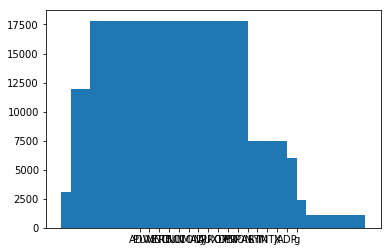

In [16]:
%matplotlib inline
plt.bar(list(basque_train_tag_distribution.keys()), basque_train_tag_distribution.values(), 'g', align='center')


In [17]:
basque_test_tag_distribution

{'NOUN': 6057,
 'PUNCT': 3904,
 'CCONJ': 1242,
 'PART': 286,
 'AUX': 2502,
 'ADJ': 1201,
 'VERB': 3851,
 'ADV': 1098,
 'PROPN': 1875,
 'DET': 826,
 'NUM': 910,
 'PRON': 168,
 'SYM': 2,
 'X': 39,
 'INTJ': 8,
 'ADP': 405}

<BarContainer object of 16 artists>

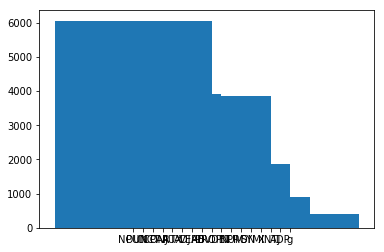

In [18]:
plt.bar(list(basque_test_tag_distribution.keys()), basque_test_tag_distribution.values(), 'g', align='center')

### Из-за масштаба мало, что видно, поэтому пояснения к графикам.
Наибольшее количество токенов в **тренировочной выборке** приходится на:
    1. существительные - 17822
    2. пунктуацию - 11934
    3. глаголы - 11556
    4. вспомогательные глаголы - 7476 
    5. имена собственные - 6004
    6. прилагательные - 3552
    
    
Наибольшее количество токенов в **тестовой выборке** приходится на:
    1. существительные - 6057
    2. пунктуацию - 3904
    3. глаголы - 3851
    4. вспомогательные глаголы - 2502 
    5. имена собственные - 1875
    6. союзы - 1242
    6. прилагательные - 1201

In [19]:
MAX_SEQLEN = 64 #максимальная длина предложения
S_MAX_FEATURES = 17565 #количество токенов в исходном словаре/тренировочной выборке
T_MAX_FEATURES = 16 #тэги

In [20]:
basque_train_unique_words

{'hamaikakoarekin',
 'azpimarratzen',
 'ezkutuan',
 'egun',
 'burtsan',
 'erakundeekiko',
 'etsaiak',
 'inozoa',
 '20-18',
 'zalantzan',
 'olasagasti',
 'bermeotik',
 'blazersen',
 'kexatzen',
 'saihestu',
 'zangoetan',
 'jendeari',
 '95/8/24',
 'prozesu',
 'lehergailua',
 'ebtik',
 'monteferrandek',
 'txapeldunen',
 'izurriteak',
 'norgehiagokan',
 'santoña-santander',
 'bihartik',
 'mosaiko',
 'tratamendu',
 'ibarrean',
 'renoko',
 'ekitaldira',
 'artaldeak',
 'afganistanerako',
 'hiztegi',
 'droga',
 'a',
 'walonako',
 'politikoetako',
 'dardaratu',
 'hong',
 'baraki',
 'jokaldi',
 'administrazioaren',
 'easen',
 'zergen',
 'fittipaldi',
 'euro',
 'aholku',
 'adingabeak',
 'etzi',
 'esprintean',
 'zerutik',
 'ziur',
 'zimelduaraziko',
 'bestelakorik',
 'mosku',
 'periodistiko',
 'hostozabalen',
 'udalbiltzari',
 'erregulartasuna',
 'baliogabeko',
 'errusia',
 'rojas',
 'azpibalorazio',
 '2.500',
 'oinaldean',
 'pobreena',
 'alfonso',
 'brasil',
 'etbko',
 'kristau-demokrata',
 'magn

#### Дальше делаем словари соответствия слов и индексов, тэгов и индексов, потому что входные и выходные данные будут последовательностью индексов и нужен будет способ расшифровки

In [21]:
word2index = {w: i + 2 for i,w in enumerate(basque_train_unique_words)} #ставим токенам в соответсвтие индекс,записываем в словарь
word2index['PAD'] = 0
word2index['UNK'] = 1 #тэг для новых слов
tag2index = {t: i + 1 for i,t in enumerate(basque_train_tags)}
tag2index['PAD'] = 0

In [22]:
word2index

{'hamaikakoarekin': 2,
 'azpimarratzen': 3,
 'ezkutuan': 4,
 'egun': 5,
 'burtsan': 6,
 'erakundeekiko': 7,
 'etsaiak': 8,
 'inozoa': 9,
 '20-18': 10,
 'zalantzan': 11,
 'olasagasti': 12,
 'bermeotik': 13,
 'blazersen': 14,
 'kexatzen': 15,
 'saihestu': 16,
 'zangoetan': 17,
 'jendeari': 18,
 '95/8/24': 19,
 'prozesu': 20,
 'lehergailua': 21,
 'ebtik': 22,
 'monteferrandek': 23,
 'txapeldunen': 24,
 'izurriteak': 25,
 'norgehiagokan': 26,
 'santoña-santander': 27,
 'bihartik': 28,
 'mosaiko': 29,
 'tratamendu': 30,
 'ibarrean': 31,
 'renoko': 32,
 'ekitaldira': 33,
 'artaldeak': 34,
 'afganistanerako': 35,
 'hiztegi': 36,
 'droga': 37,
 'a': 38,
 'walonako': 39,
 'politikoetako': 40,
 'dardaratu': 41,
 'hong': 42,
 'baraki': 43,
 'jokaldi': 44,
 'administrazioaren': 45,
 'easen': 46,
 'zergen': 47,
 'fittipaldi': 48,
 'euro': 49,
 'aholku': 50,
 'adingabeak': 51,
 'etzi': 52,
 'esprintean': 53,
 'zerutik': 54,
 'ziur': 55,
 'zimelduaraziko': 56,
 'bestelakorik': 57,
 'mosku': 58,
 'per

In [23]:
S_MAX_FEATURES += 2
T_MAX_FEATURES += 1

#### Подготовка наборов данных на вход сети:

In [24]:
#from tqdm import tqdm_notebook as tqdm 

def build_tensor(basque_sequences, num_sent, word2index, maxlen):
    data = np.empty((num_sent, ), dtype=list)
    i = 0
    #while data[-2]==None:
    while i < num_sent:
        for sent in basque_sequences:
            wids = []
            for word in sent:
                if word in word2index:
                    wids.append(word2index[word])
                else:
                    if 'UNK' in word2index:
                        wids.append(word2index['UNK'])

        data[i] = wids         
        i += 1
 
    pdata = sequence.pad_sequences(data, maxlen=maxlen, padding='post', truncating="post")
    return pdata


#### Преобразуем вид наших данных, чтобы добавить паддинги

In [25]:
train_sequences = []
for sent in basque_train_sentences:
    train_sequences+=sent

test_sequences = []
for sent in basque_test_sentences:
    test_sequences+=sent    
    

In [26]:
import time

In [36]:
%time X = build_tensor(train_sequences, len_train_sent, word2index, MAX_SEQLEN)
%time Y = build_tensor(train_sequences, len_train_sent, tag2index, MAX_SEQLEN)

%time Xtest = build_tensor(test_sequences, len_test_sent, word2index, MAX_SEQLEN)
%time Ytest = build_tensor(test_sequences, len_test_sent, tag2index, MAX_SEQLEN)

Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

KeyboardInterrupt: 

Wall time: 14min 27s
Wall time: 4min 13s
Wall time: 1min 41s


In [37]:
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

### Simple RNN

In [38]:
NUM_EPOCHS = 8

In [39]:
from keras.layers import SimpleRNN

In [40]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 64, 64)            1124288   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64, 64)            8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64, 17)            1105      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 17)            0         
Total params: 1,133,649
Trainable params: 1,133,649
Non-trainable params: 0
_________________________________________________________________


##### Оцениваем работу модели без паддингов

In [41]:
# y - correct answers - tags
# h - predictions
def evaluate(y, h, test_tags):
    new_y = []
    new_h = []
    for line in y:
        k = 0
        for i in range(len(test_tags[k])):
            new_y.append(line[i])
        k+=1
    for line in h:
        k = 0
        for i in range(len(test_tags[k])):
            new_h.append(line[i])
        k+=1
    
        
    classes = set(new_y)
    len_new_y = len(new_y)

    results = {'accuracy w/o paddings': 0}
    class_dist = {c: new_y.count(c) / len_new_y for c in classes}

    for c in classes:
        tp = set()
        fp = set()
        tn = set()
        fn = set()

        for i, h_i in enumerate(new_h):
            y_i = new_y[i]
            if h_i == y_i:
                if h_i == c:
                    tp.add((i, h_i))
                else:
                    tn.add((i, h_i))
        acc = len(tp | tn) / len(new_h)

        results['accuracy w/o paddings']  += acc * class_dist[c]
    return results

In [42]:
history = rnn_model.fit(X, np_utils.to_categorical(Y, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)])
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model.predict_classes(Xtest)


Train on 5396 samples, validate on 1080 samples
Epoch 1/8
5396/5396 [==============================] - 35s 6ms/step - loss: 0.4141 - acc: 0.9375 - val_loss: 0.0282 - val_acc: 1.0000
Epoch 2/8
5396/5396 [==============================] - 24s 4ms/step - loss: 0.0165 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 3/8
5396/5396 [==============================] - 20s 4ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 4/8
5396/5396 [==============================] - 19s 4ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 5/8
5396/5396 [==============================] - 19s 4ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 8.2156e-04 - val_acc: 1.0000
Epoch 6/8
5396/5396 [==============================] - 19s 4ms/step - loss: 8.8368e-04 - acc: 1.0000 - val_loss: 5.8783e-04 - val_acc: 1.0000
Epoch 7/8
5396/5396 [==============================] - 20s 4ms/step - loss: 6.5317e-04 - acc: 1.0000 - val_loss: 4.4746e-04 - val_acc: 1

NameError: name 'ger_test_tags' is not defined

In [44]:
prediction_rnn = evaluate(Ytest, prediction, basque_test_tags)
print(prediction_rnn)

TypeError: 'set' object does not support indexing

In [ ]:
#### Уже с третьей эпохи модель заметно переобучается

In [ ]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)])
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print ('Test score: %.3f, accuracy: %.3f' % (score, acc))
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, ger_test_tags)
print(prediction_rnn)

In [ ]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()